In [ ]:
from fastai.collab import *
from fastai.tabular.all import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/sgugger/.fastai/data/movie_lens_sample')

In [ ]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [ ]:
dls = CollabDataLoaders.from_df(ratings, bs=64, seed=42)

In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=y_range)

In [ ]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.539011,0.819069,00:01
1,0.843134,0.698604,00:00
2,0.656233,0.688964,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [ ]:
path=Config().data/'ml-100k'

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
len(ratings)

100000

In [ ]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
dls = CollabDataLoaders.from_df(rating_movie, seed=42, valid_pct=0.1, bs=64, item_name=title, path=path)

In [ ]:
dls.show_batch()

,userId,title,rating
0,695,Bean (1997),2
1,373,"River Wild, The (1994)",3
2,288,Liar Liar (1997),2
3,94,Mars Attacks! (1996),4
4,293,My Favorite Year (1982),4
5,650,Beauty and the Beast (1991),3
6,200,Terminator 2: Judgment Day (1991),5
7,113,Conspiracy Theory (1997),5
8,160,Down Periscope (1996),2
9,59,Quiz Show (1994),4


In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(dls, n_factors=40, y_range=y_range)

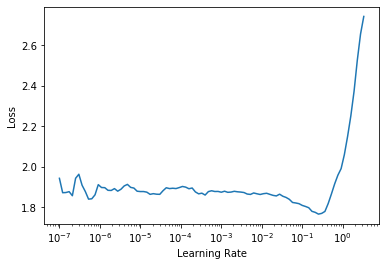

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3,  wd=1e-1)

epoch,train_loss,valid_loss,time
0,0.931693,0.953088,00:16
1,0.840349,0.870622,00:16
2,0.757327,0.820326,00:17
3,0.655944,0.803768,00:16
4,0.562621,0.803080,00:17


In [ ]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1650, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1650, 1)
)

In [ ]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3480),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3199),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2892), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2810), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2784), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2743), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2514), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2509), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2329), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2298), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2295), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2254), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2178), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2178), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2099), 'Flintstones, The (

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5769), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5740), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5597), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5412), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5299), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5277), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5270), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5267), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5005), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4942), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4938), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4844), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4650), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4602), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4561), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1449), 'Chinatown (1974)'),
 (tensor(1.0863), 'Close Shave, A (1995)'),
 (tensor(1.0594),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0126), 'Casablanca (1942)'),
 (tensor(0.9971), 'When We Were Kings (1996)'),
 (tensor(0.9898), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9893), '12 Angry Men (1957)'),
 (tensor(0.9696), 'North by Northwest (1959)'),
 (tensor(0.9677), 'Lawrence of Arabia (1962)'),
 (tensor(0.9567), 'Ran (1985)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2181), 'Home Alone 3 (1997)'),
 (tensor(-1.1975), 'Jungle2Jungle (1997)'),
 (tensor(-1.1753), 'Congo (1995)'),
 (tensor(-1.1661), 'Bio-Dome (1996)'),
 (tensor(-1.1285), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1258), "McHale's Navy (1997)"),
 (tensor(-1.0802), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0568), 'Batman & Robin (1997)'),
 (tensor(-1.0467), 'Leave It to Beaver (1997)'),
 (tensor(-1.0363), 'Mortal Kombat: Annihilation (1997)')]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8935), 'Trainspotting (1996)'),
 (tensor(0.8681), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.8247), 'Exotica (1994)'),
 (tensor(0.8018), 'Brazil (1985)'),
 (tensor(0.7887), 'Clockwork Orange, A (1971)'),
 (tensor(0.7714), 'Jude (1996)'),
 (tensor(0.7573), 'Lost Highway (1997)'),
 (tensor(0.7393), 'Keys to Tulsa (1997)'),
 (tensor(0.7232), 'Cable Guy, The (1996)'),
 (tensor(0.7216), 'Pallbearer, The (1996)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1362), 'Braveheart (1995)'),
 (tensor(-1.1113), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0690), 'Titanic (1997)'),
 (tensor(-0.9674), 'American President, The (1995)'),
 (tensor(-0.8977), "It's a Wonderful Life (1946)"),
 (tensor(-0.8572), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8516), 'Pretty Woman (1990)'),
 (tensor(-0.8425), 'Field of Dreams (1989)'),
 (tensor(-0.8065), 'Independence Day (ID4) (1996)'),
 (tensor(-0.7923), 'Back to the Future (1985)')]

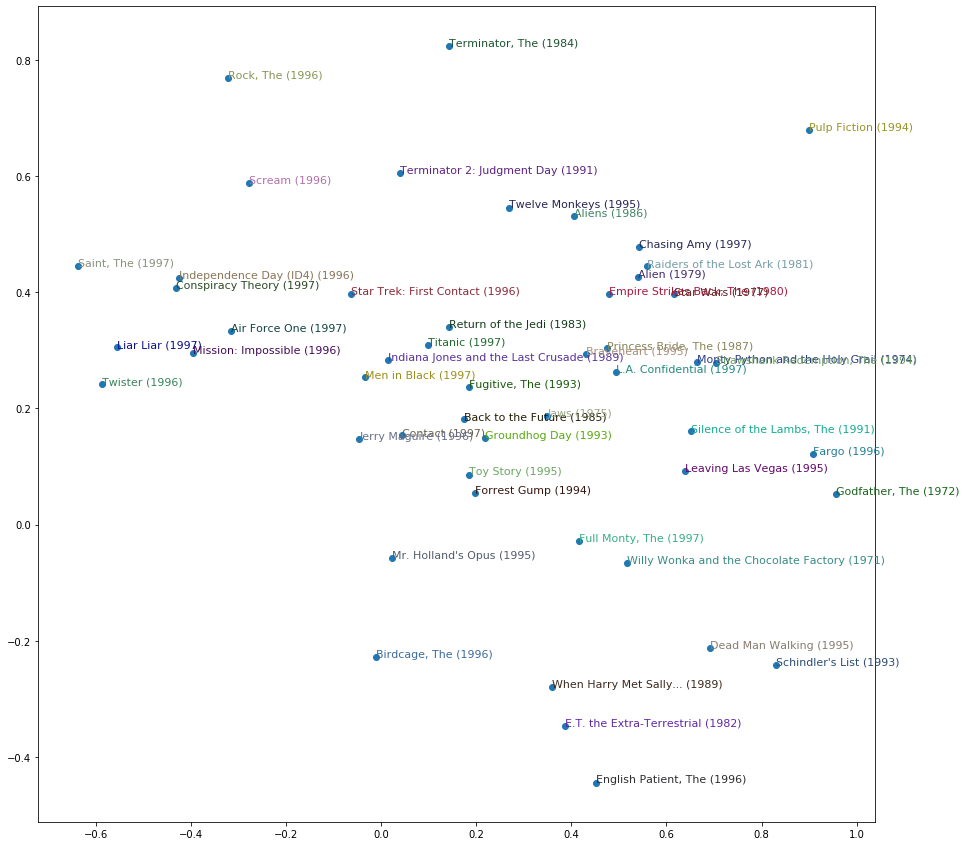

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()